In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import torch.utils.data as data
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Target high-dim performance functions

In [2]:
from juan_first_passage import juan_first_passage
#https://rprepo.readthedocs.io/en/latest/reliability_problems.html#sec-rp-300
# RP300 14 input variables - gaussian
#set_id 	 problem_id
# 1 	 15

# from gfun_213_le_frame import gfun_213_le_frame
# from le_frame import le_frame
# import le_frame_rein
# https://rprepo.readthedocs.io/en/latest/_modules/gfun_213_le_frame.html#gfun_213_le_frame
# set_id	problem_id
# 1 	14

In [75]:
# reading external dataset file 
filename_data = 'DataSet_RP300_10e5.sav'
dataset = pickle.load(open(filename_data, 'rb'))
max_sample = 2 * 10**3

x_dataset = dataset[0:max_sample, 0:15]  #15 to fuse Y in the last column of the training data
y_dataset = dataset[0:max_sample, 14]

# x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size=0.25, random_state=73)  # create splits

In [ ]:
5*10**3

In [6]:
# n_samples = 10**5
# x_dataset = np.random.normal(0, 1 , size=(n_samples, 14) )
# y_dataset = juan_first_passage(x_dataset)

## pf estimation with dataset
np.sum(y_dataset < 0)/len(y_dataset)

0.0

In [76]:
x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, train_size=0.5, random_state=73)  # create splits
x_train = torch.from_numpy(x_train.astype(np.float32)).view(-1,1000,15)  #to create input batches of 100x15
y_train = torch.from_numpy(y_train.astype(np.float32)).view(-1,1)

x_test = torch.from_numpy(x_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32)).view(-1,1)

# Creating classes for AutoEncoder (AE) and Variational AE

In [ ]:
# class to create an Autoencoder object
class AE(torch.nn.Module):
    def __init__(self, in_dim):
        
        super().__init__()
         
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        
        self.encoder = torch.nn.Sequential(
            nn.Linear(in_dim, 10),
            nn.LeakyReLU(0.1),
            nn.Linear(10, 7),
            nn.LeakyReLU(0.1),
            nn.Linear(7, 5),
            nn.LeakyReLU(0.1),
            nn.Linear(5, 3),
            )
         
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        
        self.decoder = torch.nn.Sequential(
            nn.Linear(3, 5),
            nn.LeakyReLU(0.1),
            nn.Linear(5, 7),
            nn.LeakyReLU(0.1),
            nn.Linear(7, 10),
            nn.LeakyReLU(0.1),
            nn.Linear(10, in_dim),
            )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
#to receive an individual sample estimate of 14 input dim
class VAE_small(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        
        #encoder
        self.x_hidd = nn.Linear(in_dim, 7)  
        self.mu_hidd = nn.Linear(7, 3)  
        self.sigma_hidd = nn.Linear(7, 3)
        
        #decoder         
        self.decoder = torch.nn.Sequential(
        nn.Linear(3, 5),
        nn.ReLU(),
        nn.Linear(5, 10),
        nn.ReLU(),
        nn.Linear(10, in_dim),
        )
        
        self.N = torch.distributions.Normal(0, 1)
        self.kl = 0
        
    def enconder(self, x):
        h = F.relu(self.x_hidd(x))
        mu, sigma = self.mu_hidd(h), F.relu(self.sigma_hidd(h))     #sigma should be positive
        return mu, sigma
        
    def forward(self, x):
        mu, sigma = self.enconder(x)
#         epsilon = torch.randn_like(sigma)        #reparametrization trick?
        epsilon = self.N.sample(mu.shape)
        z_reparametrized = mu + sigma*epsilon
    
        x_reconstructed = self.decoder(z_reparametrized)
        return x_reconstructed, mu, sigma

In [80]:
#to receive the complete distribution of 1000X14 dim
class VAE_large(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        
        #encoder
        self.hidden = torch.nn.Sequential(
        nn.Linear(in_dim, 8000),
        nn.LeakyReLU(0.1),
        nn.Linear(8000, 2000),
        nn.LeakyReLU(0.1),
        nn.Linear(2000, 1000),
        nn.LeakyReLU(0.1),
        nn.Linear(1000, 50),
        nn.LeakyReLU(0.1),
        )
        
        self.mu_hidd = nn.Linear(50, 2)  
        self.sigma_hidd = nn.Linear(50, 2)
        
        #decoder         
        self.decoder = torch.nn.Sequential(
        nn.Linear(2, 100),
        nn.LeakyReLU(0.1),
        nn.Linear(100, 2000),
        nn.LeakyReLU(0.1),
        nn.Linear(2000, 8000),
        nn.LeakyReLU(0.1),
        nn.Linear(8000, in_dim),
        )
        
        self.N = torch.distributions.Normal(0, 1)
        self.kl = 0
        
    def enconder(self, x):
#         x = torch.flatten(x, start_dim=0)
        x_hidd = self.hidden(x)
        
        mu, sigma = self.mu_hidd(x_hidd), torch.exp(self.sigma_hidd(x_hidd))     #sigma should be positive
        return mu, sigma
        
    def forward(self, x):
        mu, sigma = self.enconder(x)
#         epsilon = torch.randn_like(sigma)        #reparametrization trick?
        epsilon = self.N.sample(mu.shape)
    
        z_reparametrized = mu + sigma*epsilon
    
        x_reconstructed = self.decoder(z_reparametrized)
        return x_reconstructed, mu, sigma

In [54]:
#to receive batches distribution of 100X14 dim
class VAE_semilarge(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        
        #encoder
        self.hidden = torch.nn.Sequential(
        nn.Linear(in_dim, 3000),
        nn.LeakyReLU(0.1),
        nn.Linear(3000, 1000),
        nn.LeakyReLU(0.1),
        nn.Linear(1000, 500),
        nn.LeakyReLU(0.1),
        nn.Linear(500, 50),
        nn.LeakyReLU(0.1),
        )
        
        self.mu_hidd = nn.Linear(50, 2)  
        self.sigma_hidd = nn.Linear(50, 2)
        
        #decoder         
        self.decoder = torch.nn.Sequential(
        nn.Linear(2, 50),
        nn.LeakyReLU(0.1),
        nn.Linear(50, 1000),
        nn.LeakyReLU(0.1),
        nn.Linear(1000, 3000),
        nn.LeakyReLU(0.1),
        nn.Linear(3000, in_dim),
        )
        
        self.N = torch.distributions.Normal(0, 1)
        self.kl = 0
        
    def enconder(self, x):
#         x = torch.flatten(x, start_dim=0)
        x_hidd = self.hidden(x)
        
        mu, sigma = self.mu_hidd(x_hidd), torch.exp(self.sigma_hidd(x_hidd))     #sigma should be positive
        return mu, sigma
        
    def forward(self, x):
        mu, sigma = self.enconder(x)
#         epsilon = torch.randn_like(sigma)        #reparametrization trick?
        epsilon = self.N.sample(mu.shape)
    
        z_reparametrized = mu + sigma*epsilon
    
        x_reconstructed = self.decoder(z_reparametrized)
        return x_reconstructed, mu, sigma

In [81]:
# VariationalAutoencoder(15)
in_dim = x_train.shape[1] * 15    #complete distribution

#model initialization
network_VAE = VAE_large(in_dim)   #size of high-dim input space
print(network_VAE)

VAE_large(
  (hidden): Sequential(
    (0): Linear(in_features=15000, out_features=8000, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=8000, out_features=2000, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=2000, out_features=1000, bias=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=1000, out_features=50, bias=True)
    (7): LeakyReLU(negative_slope=0.1)
  )
  (mu_hidd): Linear(in_features=50, out_features=2, bias=True)
  (sigma_hidd): Linear(in_features=50, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=100, out_features=2000, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=2000, out_features=8000, bias=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=8000, out_features=15000, bias=True)
  )
)


In [82]:
train = data.TensorDataset(x_train, x_train)    #it should be (x_train, y_train) but changed to test diff dim
trainloader = data.DataLoader(train, batch_size=1, shuffle=False)

x,_ = next(iter(trainloader))  #to fix the x value in the reconstruction training

Train with a single large data input

1it [00:03,  3.75s/it, KL=0.0583, recon_loss=0.00362]
1it [00:03,  3.52s/it, KL=1.03, recon_loss=0.0209]
1it [00:03,  3.25s/it, KL=0.298, recon_loss=0.19]
1it [00:03,  3.15s/it, KL=0.381, recon_loss=0.0153]
1it [00:03,  3.14s/it, KL=0.189, recon_loss=0.032]
1it [00:03,  3.07s/it, KL=0.137, recon_loss=0.0204]
1it [00:03,  3.21s/it, KL=0.0139, recon_loss=0.0916]
1it [00:03,  3.18s/it, KL=0.0453, recon_loss=0.0115]
1it [00:03,  3.12s/it, KL=0.102, recon_loss=0.0159]
1it [00:03,  3.12s/it, KL=0.0249, recon_loss=0.0128]
1it [00:03,  3.20s/it, KL=0.008, recon_loss=0.0286]
1it [00:03,  3.11s/it, KL=0.0247, recon_loss=0.0207]
1it [00:03,  3.10s/it, KL=0.0338, recon_loss=0.0158]
1it [00:03,  3.05s/it, KL=0.0794, recon_loss=0.0354]
1it [00:02,  2.84s/it, KL=0.155, recon_loss=0.0253]
1it [00:03,  3.15s/it, KL=0.0108, recon_loss=0.0139]
1it [00:03,  3.12s/it, KL=0.14, recon_loss=0.0165]
1it [00:03,  3.15s/it, KL=0.0997, recon_loss=0.0126]
1it [00:03,  3.24s/it, KL=0.0789, recon_loss=0.0101]
1it [0

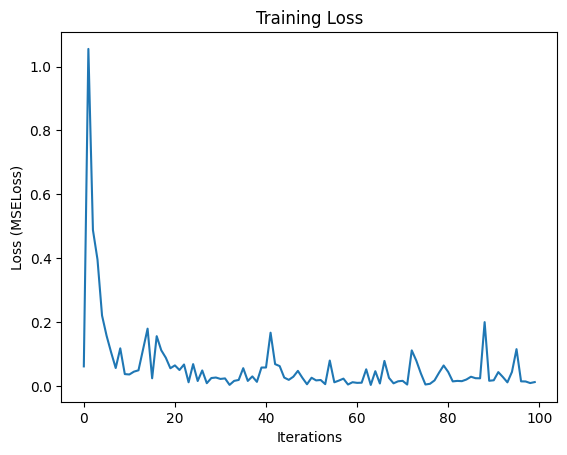

In [89]:
# we use the MSE loss as criterion
criterion = nn.MSELoss()

# we create an instance of the SGD class that will make the updates for us
# optimizer = optim.SGD(params= network.parameters(), lr=.1)
optimizer = optim.Adam(params= network_VAE.parameters(), lr = 2e-4)  #Karpathy constant?

# train = data.TensorDataset(x_train, y_train)    #it should be (x_train, y_train) but changed to test diff dim
# trainloader = data.DataLoader(train, batch_size=1, shuffle=False)

# test = data.TensorDataset(x_test, y_test)
# testloader = data.DataLoader(test, batch_size=32, shuffle=False)

num_epochs = 100
train_avg_loss = []

device = 'cpu'

network_VAE.to(device)

# x = x_train

for epoch in range(num_epochs):
    
    loop = tqdm(enumerate(trainloader))
    train_losses = []
    
#     x = torch.flatten(x_train, start_dim=0)   #to output the whole training dataset
    
    for i, (_ , _) in loop: #call the variables needed for training (x only for reconstruction loss)

#         x = x.to(device) # GPU

        x = torch.flatten(x, start_dim=0)   #to output the whole training dataset
    
        x_reconstructed, mu, sigma = network_VAE(x)
        
        reconstruction_loss = criterion(x_reconstructed, x)
        KL_div = - torch.sum( 1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2) )

        loss = reconstruction_loss + KL_div

        train_losses.append(loss.detach())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_postfix(recon_loss=reconstruction_loss.item(), KL=KL_div.item())

    train_avg_loss.append(sum(train_losses)/len(train_losses))

# Move everything back to the CPU
train_avg_loss = torch.tensor(train_avg_loss, device = 'cpu')

fig, axs = plt.subplots(1, 1)
axs.set_title('Training Loss')
axs.plot(train_avg_loss)
axs.set_xlabel('Iterations')
axs.set_ylabel('Loss (MSELoss)')
plt.show()

In [98]:
reconstructed, mean, sigma = network_VAE(x)

# reconstructed.view(500,15),mean, sigma

In [100]:
x.view(500,15)

RuntimeError: shape '[500, 15]' is invalid for input of size 15000

Sampling from latent space

In [101]:
mean_arr, sigma_arr = mean.cpu().detach().numpy(), sigma.cpu().detach().numpy()

In [102]:
z=np.zeros(2)
z[0] = np.random.normal(mean_arr[0], sigma_arr[0], 1)
z[1] = np.random.normal(mean_arr[1], sigma_arr[1], 1)

In [26]:
z_sample = torch.from_numpy(z.astype(np.float32))
fused_decoded = network_VAE.decoder(z_sample)
print(fused_decoded.view(500,15))

tensor([[-0.9570,  0.7325,  0.5385,  ..., -0.2973,  0.6628,  0.8822],
        [ 0.8396,  0.3822, -0.2837,  ..., -0.7619, -0.4144,  0.9518],
        [ 1.3152, -1.6238,  0.4687,  ...,  1.8419,  0.7364,  0.7177],
        ...,
        [ 0.7534,  1.1277,  0.5747,  ...,  0.8037,  1.4336,  0.9473],
        [ 0.3045, -1.5458,  0.2144,  ..., -0.2665, -0.7552,  0.7370],
        [-0.0541, -0.0731,  0.2497,  ...,  0.6853,  0.7703,  0.7703]],
       grad_fn=<ViewBackward0>)


In [103]:
fused_decoded_arr = fused_decoded.cpu().detach().numpy()
fused_decoded_arr = fused_decoded_arr.reshape(100,15)

x_decoded, y_decoded = fused_decoded_arr[:, 0:14], fused_decoded_arr[:, 14]

ValueError: cannot reshape array of size 15000 into shape (100,15)

In [104]:
y_sim_decod = juan_first_passage(x_decoded)

In [105]:
#reproduction MSE
np.mean((y_sim_decod - y_decoded)**2)

0.023604962470882094

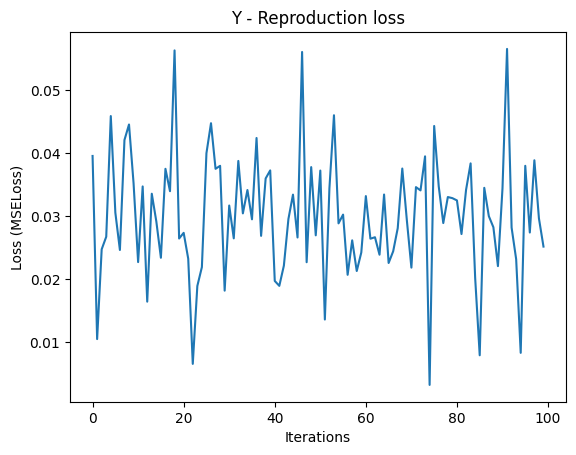

In [106]:
num_exp = 100
produc_loss = []

for exp in range(num_exp):
    
    z=np.zeros(2)
    z[0] = np.random.normal(mean_arr[0], sigma_arr[0], 1)
    z[1] = np.random.normal(mean_arr[1], sigma_arr[1], 1)
    
    z_sample = torch.from_numpy(z.astype(np.float32))
    fused_decoded = network_VAE.decoder(z_sample)
    
    fused_decoded_arr = fused_decoded.cpu().detach().numpy()
    fused_decoded_arr = fused_decoded_arr.reshape(1000,15)
    
    x_decoded, y_decoded = fused_decoded_arr[:, 0:14], fused_decoded_arr[:, 14]
    
    y_sim_decod = juan_first_passage(x_decoded)
    
    loss = np.mean((y_sim_decod - y_decoded)**2)
    
    produc_loss.append(loss.item())
    
# print(produc_loss)
fig, axs = plt.subplots(1, 1)
axs.set_title('Y - Reproduction loss')
axs.plot(produc_loss)
axs.set_xlabel('Iterations')
axs.set_ylabel('Loss (MSELoss)')
plt.show()

Training over a stochastic gradient descent

In [ ]:
# we use the MSE loss as criterion
criterion = nn.MSELoss()

# we create an instance of the SGD class that will make the updates for us
# optimizer = optim.SGD(params= network.parameters(), lr=.1)
optimizer = optim.Adam(params= network_VAE.parameters(), lr = 5e-3)  #Karpathy constant?

train = data.TensorDataset(x_train, y_train)
trainloader = data.DataLoader(train, batch_size=32, shuffle=True)

test = data.TensorDataset(x_test, y_test)
testloader = data.DataLoader(test, batch_size=32, shuffle=False)

num_epochs = 100
train_avg_loss = []
test_avg_loss = []

device = 'cpu'

network_VAE.to(device)

for epoch in range(num_epochs):
    loop = tqdm(enumerate(trainloader))
    
    train_losses = []
    test_losses = []

    for i, (x, _) in loop:    #we can omit 'y' value 
        x = x.to(device) # GPU
        
        x_reconstructed, mu, sigma = network_VAE(x)
        
        reconstruction_loss = criterion(x_reconstructed, x)
        KL_div = -torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))

        loss = reconstruction_loss + KL_div
        
        train_losses.append(loss.detach())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loop.set_postfix(loss=loss.item())

    with torch.no_grad():   

        for x, _ in testloader:
            x = x.to(device) # GPU
            
            x_reconstructed, mu, sigma = network_VAE(x)
            KL_div_test = torch.mean(-0.5 *torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2), dim = 1), dim = 0)
#             KL_div_test = -0.5 *torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
    
            loss_test = criterion(x_reconstructed, x) + KL_div_test
            test_losses.append(loss_test)
        
    train_avg_loss.append(sum(train_losses)/len(train_losses))
    test_avg_loss.append(sum(test_losses)/len(test_losses))

# Move everything back to the CPU
train_avg_loss = torch.tensor(train_avg_loss, device = 'cpu')
test_avg_loss = torch.tensor(test_avg_loss, device = 'cpu')

fig, axs = plt.subplots(1, 1)
axs.set_title('Training Loss')
axs.plot(train_avg_loss)
axs.plot(test_avg_loss)
axs.set_xlabel('Iterations')
axs.set_ylabel('Loss (MSELoss)')
plt.show()

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        
        self.linear1 = nn.Linear(in_dim, 8)
        self.linear2 = nn.Linear(8, 3)     #to output the mean
        self.linear3 = nn.Linear(8, 3)     #to output the std. dev.
        
    def forward(self, x):
        
        x = F.relu(self.linear1(x))   
        self.mu =  self.linear2(x)
        self.sigma = (self.linear3(x))    #torch.exp(self.linear3(x))    #exponential to ensure positive values?
        
        z = self.mu + self.sigma*self.N.sample(self.mu.shape)   #reparametrization trick?
        z = 
        
        self.kl2 = torch.sum(((self.sigma**2 + self.mu**2)*0.5 + torch.log(1/self.sigma) ) - 1/2
        self.kl = (self.sigma**2 + self.mu**2 - torch.log(self.sigma) - 1/2).sum()
        
        return z
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.encoder = VariationalEncoder(in_dim)
                
        self.decoder = torch.nn.Sequential(
        nn.Linear(3, 7),
        nn.ReLU(),
        nn.Linear(7, 10),
        nn.ReLU(),
        nn.Linear(10, in_dim),
        )
        
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

Generating samples and splitting the data for training and test

In [ ]:
# dataset[:, 0:14] = x_dataset_2
# dataset[:, 14] = y_dataset_2

# filename_data = 'DataSet_RP300_10e6.sav'
# pickle.dump(dataset, open(filename_data, 'wb'))

n_split = int(0.3 * n_samples) #splitting 30 - 70 %

x_train = torch.from_numpy(x_dataset[n_split:].astype(np.float32))
y_train = torch.from_numpy(y_dataset[n_split:].astype(np.float32)).view(-1,1)

x_test = torch.from_numpy(x_dataset[:n_split].astype(np.float32))
y_test = torch.from_numpy(y_dataset[:n_split].astype(np.float32)).view(-1,1)

Setting up losses criterion, optimizer and dataloaders

In [ ]:
if torch.cuda.is_available() == True:
    device = 'cuda'
else:
    device = 'cpu'
    
print(device)

In [ ]:
# filename_data = 'network_MLP.sav'
# pickle.dump(network, open(filename_data, 'wb'))

# VAE

In [ ]:
# we use the MSE loss as criterion
criterion = nn.MSELoss()

# we create an instance of the SGD class that will make the updates for us
# optimizer = optim.SGD(params= network.parameters(), lr=.1)
optimizer = optim.Adam(params= network_VAE.parameters(), lr = 1e-3, weight_decay = 1e-8)

train = data.TensorDataset(x_train, y_train)
trainloader = data.DataLoader(train, batch_size=8, shuffle=True)

test = data.TensorDataset(x_test, y_test)
testloader = data.DataLoader(test, batch_size=8, shuffle=False)

In [ ]:
num_epochs = 50
train_avg_loss = []
test_avg_loss = []

device = 'cpu'

network_VAE.to(device)

for i in range(num_epochs):

    train_losses = []
    test_losses = []

    for x, _ in trainloader:    #we can omit 'y' value 
        x = x.to(device) # GPU
        
        reconstructed = network_VAE(x)
        loss = criterion(reconstructed, x) + network_VAE.encoder.kl
        train_losses.append(loss.detach())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():   

        for x, _ in testloader:
            x = x.to(device) # GPU
            
            reconstructed = network_VAE(x)
            loss = criterion(reconstructed, x)
            test_losses.append(loss)

    train_avg_loss.append(sum(train_losses)/len(train_losses))
    test_avg_loss.append(sum(test_losses)/len(test_losses))

# Move everything back to the CPU
train_avg_loss = torch.tensor(train_avg_loss, device = 'cpu')
test_avg_loss = torch.tensor(test_avg_loss, device = 'cpu')

fig, axs = plt.subplots(1, 1)
axs.set_title('Training Loss')
axs.plot(train_avg_loss)
axs.plot(test_avg_loss)
axs.set_xlabel('Iterations')
axs.set_ylabel('Loss (MSELoss)')
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 1)
axs.set_title('Training Loss')
axs.plot(train_avg_loss)
axs.plot(test_avg_loss)
axs.set_xlabel('Iterations')
axs.set_ylabel('Loss (MSELoss)')
plt.show()

In [ ]:
# VariationalAutoencoder(14)

#model initialization
network_VAE = VariationalAutoencoder(14)   #size of high-dim input space
print(network_VAE)

In [ ]:
torch.cuda.empty_cache()

# Training AE

In [ ]:
#model initialization
network_AE = AE(14)   #size of high-dim input space
print(network_AE)

In [ ]:
# we use the MSE loss as criterion
criterion = nn.MSELoss()

# we create an instance of the SGD class that will make the updates for us
# optimizer = optim.SGD(params= network.parameters(), lr=.1)
optimizer = optim.Adam(params= network_AE.parameters(), lr = 1e-3, weight_decay = 1e-8)

train = data.TensorDataset(x_train, y_train)
trainloader = data.DataLoader(train, batch_size=128, shuffle=True)

test = data.TensorDataset(x_test, y_test)
testloader = data.DataLoader(test, batch_size=128, shuffle=False)

In [ ]:
num_epochs = 50
train_avg_loss = []
test_avg_loss = []

# device = 'cpu'

network_AE.to(device)

for i in range(num_epochs):

    train_losses = []
    test_losses = []

    for _, _ in trainloader:    #we can omit 'y' value 
        x = x.to(device)
        
        reconstructed = network_AE(x)
        loss = criterion(reconstructed, x)
        train_losses.append(loss.detach())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():   

        for _, _ in testloader:
#             x = x.to(device)
            
            reconstructed = network_AE(x)
            loss = criterion(reconstructed, x)
            test_losses.append(loss)

    train_avg_loss.append(sum(train_losses)/len(train_losses))
    test_avg_loss.append(sum(test_losses)/len(test_losses))
    
# Move everything back to the CPU
train_avg_loss = torch.tensor(train_avg_loss, device = 'cpu')
test_avg_loss = torch.tensor(test_avg_loss, device = 'cpu')

    
fig, axs = plt.subplots(1, 1)
axs.set_title('Training Loss')
axs.plot(train_avg_loss)
axs.plot(test_avg_loss)
axs.set_xlabel('Iterations')
axs.set_ylabel('Loss (MSELoss)')
plt.show()

In [ ]:
num_epochs = 100
train_avg_loss = []
test_avg_loss = []

# device = 'cpu'

network_AE.to(device)

for i in range(num_epochs):

    train_losses = []
    test_losses = []

    for x, _ in trainloader:    #we can omit 'y' value 
        x = x.to(device)
        
        reconstructed = network_AE(x)
        loss = criterion(reconstructed, x)
        train_losses.append(loss.detach())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():   

        for x, _ in testloader:
            x = x.to(device)
            
            reconstructed = network_AE(x)
            loss = criterion(reconstructed, x)
            test_losses.append(loss)

    train_avg_loss.append(sum(train_losses)/len(train_losses))
    test_avg_loss.append(sum(test_losses)/len(test_losses))
    
# Move everything back to the CPU
train_avg_loss = torch.tensor(train_avg_loss, device = 'cpu')
test_avg_loss = torch.tensor(test_avg_loss, device = 'cpu')

    
fig, axs = plt.subplots(1, 1)
axs.set_title('Training Loss')
axs.plot(train_avg_loss)
axs.plot(test_avg_loss)
axs.set_xlabel('Iterations')
axs.set_ylabel('Loss (MSELoss)')
plt.show()

In [ ]:
#lr = 1e-3, batchsize=128, weight_decay = 1e-8
#latent = 5

# (encoder): Sequential(
#     (0): Linear(in_features=14, out_features=12, bias=True)
#     (1): LeakyReLU(negative_slope=0.1)
#     (2): Linear(in_features=12, out_features=10, bias=True)
#     (3): LeakyReLU(negative_slope=0.1)
#     (4): Linear(in_features=10, out_features=7, bias=True)
#     (5): LeakyReLU(negative_slope=0.1)
#     (6): Linear(in_features=7, out_features=5, bias=True)
#   )

# fig, axs = plt.subplots(1, 1)
# axs.set_title('Training Loss')
# axs.plot(train_avg_loss)
# axs.plot(test_avg_loss)
# axs.set_xlabel('Iterations')
# axs.set_ylabel('Loss (MSELoss)')
# plt.show()

Pf estimation

In [ ]:
# #loading network
# filename_data = 'network_MLP.sav'
# network = pickle.load(open(filename_data, 'rb'))

In [ ]:
point = 200
samplex = torch.from_numpy(x_dataset[point].astype(np.float32)).to(device)

y_dataset[point], network(samplex)

In [ ]:
np.sum(y_dataset < 0)/len(y_dataset)

In [ ]:
n_pred = 10**6
# x_pred = np.random.rand(n_pred, 14)
x_pred = np.random.normal(0, 1 , size=(n_samples, 14) )

x_pred = torch.from_numpy(x_pred.astype(np.float32)).to(device)

# x_pred = torch.randn(n_pred, 14, device=device)

y_pred = network(x_pred)   #MLP

np.sum(y_pred.cpu().detach().numpy() < 0)

# np.sum(y_pred < 0)/len(y_pred)

In [ ]:
counts, bins = np.histogram(y_pred.cpu().detach().numpy())
plt.stairs(counts, bins)

In [ ]:
lat_var = 2
counts, bins = np.histogram(y_pred_AE[:, lat_var].cpu().detach().numpy())
plt.stairs(counts, bins)

np.sum(y_pred.cpu().detach().numpy() < 0)

In [ ]:
negative = y_pred < 0
negative.sum(dim = 0)

In [ ]:
point = 10
samplex = x_dataset[point]
sampley = y_dataset[point]

samplex_torch = torch.from_numpy(x_dataset[point].astype(np.float32))